# Hyperbolic Embedding of Multiplex Stochastic Block Model Networks

**Copyright (c) 2025, Martin Guillemaud. All rights reserved.**  
*Licensed under BSD 3-Clause License. See LICENSE file for details.*

This notebook demonstrates how to visualize multiplex networks in hyperbolic space using our MLNHypEmb embedding method. We focus on networks generated using the Stochastic Block Model (SBM), which creates networks with clear community structures. The visualization shows:

- Multiple network layers embedded simultaneously in hyperbolic space
- Node positions reflecting both community structure and network topology
- Node sizes proportional to node importance (degree)
- Community membership indicated by node colors
- Each layer visualized in a separate 2D hyperbolic disk

This visualization technique helps reveal both the global organization of the multiplex network and the specific patterns within each layer, making it particularly useful for analyzing complex multi-layer systems.

### Import usefull librairies

In [1]:
# Import required libraries for the multilayer network analysis and visualization

# Custom modules for data generation and embedding
from src.OpenData import generate_sbm_multilayer  # Generate stochastic block model for multilayer networks
from src.EmbeddingMethod import MlHypEmb         # Hyperbolic embedding method for multilayer networks

# Scientific computing and visualization libraries
import numpy as np                # For numerical operations and array handling
import matplotlib.pyplot as plt   # For creating visualizations
import networkx as nx            # For graph/network operations and analysis

### Generate Multilayers SBM model 

In [2]:
# Parameters for the Stochastic Block Model (SBM)
n_nodes = 100        # Total number of nodes in each layer
n_layers = 3         # Number of network layers
n_communities = 3    # Number of communities/blocks in the network
p_intra = 0.16      # Probability of connection within communities
p_inter = 0.06      # Probability of connection between communities
mu = 20             # Coupling parameter for emebdding
beta = 5            # Parameter for inter layers connexions

# Define layer identifiers
layers_names = np.arange(n_layers)

# Generate multilayer SBM model
# Returns:
# - G_tot: List of NetworkX graphs (one per layer)
# - mat_tot: List of adjacency matrices
# - G_global: Global adjacency matrix combining all layers
# - node_com: Dictionary mapping nodes to their community assignments
G_tot, mat_tot, G_global, node_com = generate_sbm_multilayer(
    n_nodes=n_nodes,             
    n_layers=n_layers,           
    n_communities=n_communities, 
    p_intra=p_intra,            
    p_inter=p_inter,            
    mu=mu,                      
    beta=beta                    
)


### Embed Multilayer SBM model in Poincaré Disk 

In [3]:
# Create embedding object with hyperbolic parameters
Emb_obj = MlHypEmb(preweight=True, weight='weight', beta=2500, eta='auto', 
                   method='Isomap', beta_dist=10, metric='precomputed', 
                   n_neighbors='auto', radius='degree')

# Load multilayer network data into embedding object
Emb_obj.Load_data(matrices=mat_tot, mu_mat=None, L_global=G_global)

# Compute the hyperbolic embedding
Emb_obj.Embedding(n_jobs=-1)


[I] Object of class MlHypEmb well initiated


### Vizualization 

Plotting layer: 0 0
Plotting layer: 1 1
Plotting layer: 2 2


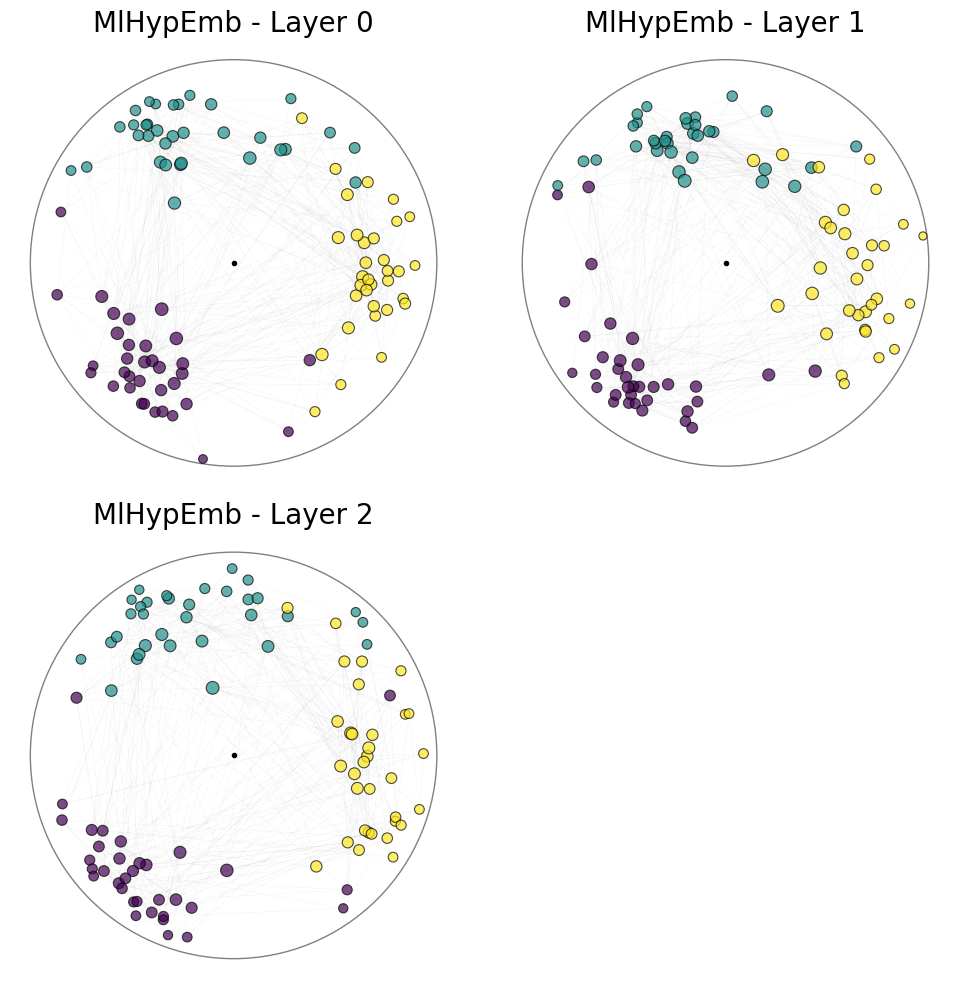

In [4]:
## Visualization of Multiplex Network Embeddings

# Set up the visualization parameters
fig = plt.figure(figsize=(5 * (n_layers + 1) // 2, 5 * 2))  # Dynamic figure size based on number of layers
plt.rcParams['axes.linewidth'] = 2  # Enhanced axis line width for better visibility

# Process and visualize each layer of the multiplex network
for layer_i in range(len(layers_names)):
    # Extract layer identification information
    layer_id = list(layers_names)[layer_i]
    layer_name = layers_names[layer_id]
    
    print('Plotting layer:', layer_name, layer_id)
    
    # Create subplot for current layer
    ax1 = fig.add_subplot(2, (n_layers + 1) // 2, layer_i + 1)
    
    # Get network and embedding data for current layer
    G = G_tot[layer_i]  # Network structure
    pos_G = Emb_obj.embeddings[layer_i]  # Node positions in hyperbolic space
    
    # Create dictionary of node positions for NetworkX
    pos_G_d = {node: pos_G[i, :] for i, node in enumerate(G.nodes())}

    # Plot reference point and boundary
    ax1.plot([0], [0], 'o', color='black', markersize=3)  # Origin point
    circle = plt.Circle((0, 0), 1, edgecolor='gray', facecolor='none', linewidth=1)  # Unit circle boundary
    ax1.add_artist(circle)

    # Calculate node sizes based on weighted degree centrality
    deg = np.array(list(dict(G.degree(weight='weight')).values()))
    node_size = np.sqrt(deg + 1) * 20  # Scale node sizes for better visualization

    # Visualize nodes with community colors
    nx.draw_networkx_nodes(
        G, pos_G_d, node_size=node_size, ax=ax1, 
        node_color=list(node_com.values()),  # Color nodes by community
        node_shape='o', edgecolors='k', linewidths=0.8, alpha=0.7
    )
    
    # Visualize edges
    nx.draw_networkx_edges(
        G, pos_G_d, width=0.3, ax=ax1, 
        edge_color='grey', alpha=0.1  # Light grey edges for better node visibility
    )

    # Configure plot aesthetics
    ax1.set_xlim(-1.1, 1.1)
    ax1.set_ylim(-1.1, 1.1)
    ax1.axis("off")  # Hide axes for cleaner visualization
    ax1.set_title(f'MlHypEmb - Layer {layer_name}', fontsize=20)
    ax1.set_aspect('equal', 'box')  # Maintain circular shape

# Adjust layout for optimal spacing
fig.tight_layout()

# Display the visualization
#plt.savefig('sbm_ml_embed_1.pdf')
plt.show()


[I] Object of class MlHypEmb well initiated
[I] Object of class MlHypEmb well initiated
[I] Object of class MlHypEmb well initiated
Plot layer: 0, ID: 0
Plot layer: 1, ID: 1
Plot layer: 2, ID: 2


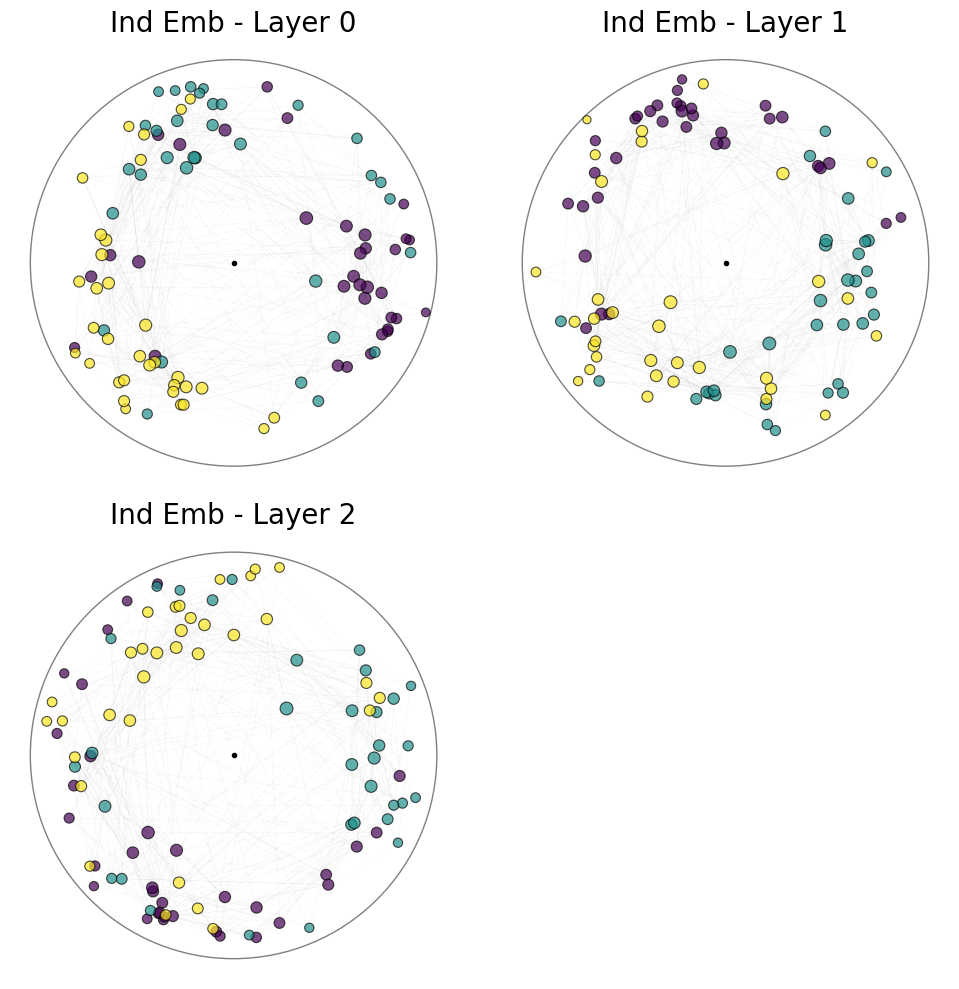

In [5]:
### Visualization of Independent Layer Embeddings ###

## --- Embed each layer separately --- ##

# Initialize a list to store individual embeddings for each layer
emb_layers_tot = []

# Process each layer independently through hyperbolic embedding
for mat in mat_tot:
    # Initialize embedding object with optimized parameters for hyperbolic space
    Emb_obj_ind = MlHypEmb(preweight=True, weight='weight', beta=2500, eta='auto',
                       method='Isomap', beta_dist=100, metric='precomputed',
                       n_neighbors='auto', radius='degree')
    
    # Process single layer matrix and compute its global structure
    Emb_obj_ind.Load_data(matrices=[mat], mu_mat=None, L_global=mat)
    
    # Generate hyperbolic embedding for the current layer
    Emb_obj_ind.Embedding(n_jobs=-1)

    # Store the 2D embedding coordinates
    emb_layers_tot.append(Emb_obj_ind.embeddings[0])

## --- Visualize layer-wise embeddings --- ##

# Configure visualization layout
fig = plt.figure(figsize=(5 * (n_layers + 1) // 2, 5 * 2))
plt.rcParams['axes.linewidth'] = 2

# Generate individual plots for each layer
for layer_i in range(len(layers_names)):
    layer_id = list(layers_names)[layer_i]
    layer_name = layers_names[layer_id]
    
    print(f"Plot layer: {layer_name}, ID: {layer_id}")
    
    # Create subplot and extract layer-specific data
    ax1 = fig.add_subplot(2, (n_layers + 1) // 2, layer_i + 1)
    G = G_tot[layer_i]
    pos_G = emb_layers_tot[layer_i]
    
    # Map node IDs to their embedded coordinates
    pos_G_d = {node: pos_G[i, :] for i, node in enumerate(G.nodes())}
    
    # Add reference points for hyperbolic space
    ax1.plot([0], [0], 'o', color='black', markersize=3)  # Origin
    circle = plt.Circle((0, 0), 1, edgecolor='gray', facecolor='none', linewidth=1)  # Unit disk boundary
    ax1.add_artist(circle)

    # Scale node sizes based on connectivity
    deg = np.array(list(dict(G.degree(weight='weight')).values()))
    node_size = np.sqrt(deg + 1) * 20

    # Visualize nodes with community-based coloring
    nx.draw_networkx_nodes(G, pos_G_d, node_size=node_size, ax=ax1,
                           node_color=list(node_com.values()),
                           node_shape='o', edgecolors='k',
                           linewidths=0.8, alpha=0.7)
    
    # Add network edges with transparency
    nx.draw_networkx_edges(G, pos_G_d, width=0.3, ax=ax1,
                          edge_color='grey', alpha=0.1)

    # Configure subplot aesthetics
    ax1.set_xlim(-1.1, 1.1)
    ax1.set_ylim(-1.1, 1.1)
    ax1.axis("off")
    ax1.set_title(f'Ind Emb - Layer {layer_name}', fontsize=20)
    ax1.set_aspect('equal', 'box')

# Optimize subplot layout
fig.tight_layout()

# Display final visualization
#plt.savefig('sbm_ind_embed_1.pdf')
plt.show()
